In [1]:
import pandas as pd
import os
current_loc = os.getcwd()
expenses = pd.read_csv(os.path.join(os.path.dirname(current_loc), 'data', 'macro_indicators', 'expenses.csv'))
gdp = pd.read_csv(os.path.join(os.path.dirname(current_loc), 'data', 'macro_indicators', 'gdp.csv'))
gns = pd.read_csv(os.path.join(os.path.dirname(current_loc), 'data', 'macro_indicators', 'goods_and_services.csv'))
index_consumer_services = pd.read_csv(os.path.join(os.path.dirname(current_loc), 'data', 'macro_indicators', 'index_consumer_services.csv'))
exchange_rate = pd.read_csv(os.path.join(os.path.dirname(current_loc), 'data', 'macro_indicators', 'pound-dollar-exchange-rate-historical-chart.csv'))
unemployment = pd.read_csv(os.path.join(os.path.dirname(current_loc), 'data', 'macro_indicators', 'unemployment.csv'))
vix_greed = pd.read_csv(os.path.join(os.path.dirname(current_loc), 'Model Pipeline', 'datasets', 'VIX_feargreed','spy_vix_fear_greed_2011_2023.csv'))

gdp = gdp.rename(columns={'DATE': 'date'})
gns = gns.iloc[:,:8]
gns['date'] = pd.to_datetime(gns['date'], format='%d/%m/%Y')
gdp['date'] = pd.to_datetime(gns['date'], format='%d/%m/%Y')
expenses['date'] = pd.to_datetime(gns['date'], format='%d/%m/%Y')
unemployment = unemployment.iloc[:128,:]

quarterly_data = expenses.merge(gdp, on='date', how='left').merge(gns, on='date', how='left')
quarterly_data = quarterly_data.drop(['exports', 'exports_goods', 'exports_services', 'imports', 'imports_goods', 'imports_services','expenses'],axis=1)
monthly_data = unemployment.merge(index_consumer_services,on='date',how='left')
daily_data = exchange_rate
quarterly_data.head()

,date,GDP,net_export_goods_and_services
0,2014-01-01,17197.738,"-510,088"
1,2014-04-01,17518.508,"-505,404"
2,2014-07-01,17804.228,"-489,357"
3,2014-10-01,17912.079,"-530,751"
4,2015-01-01,18063.529,"-526,432"


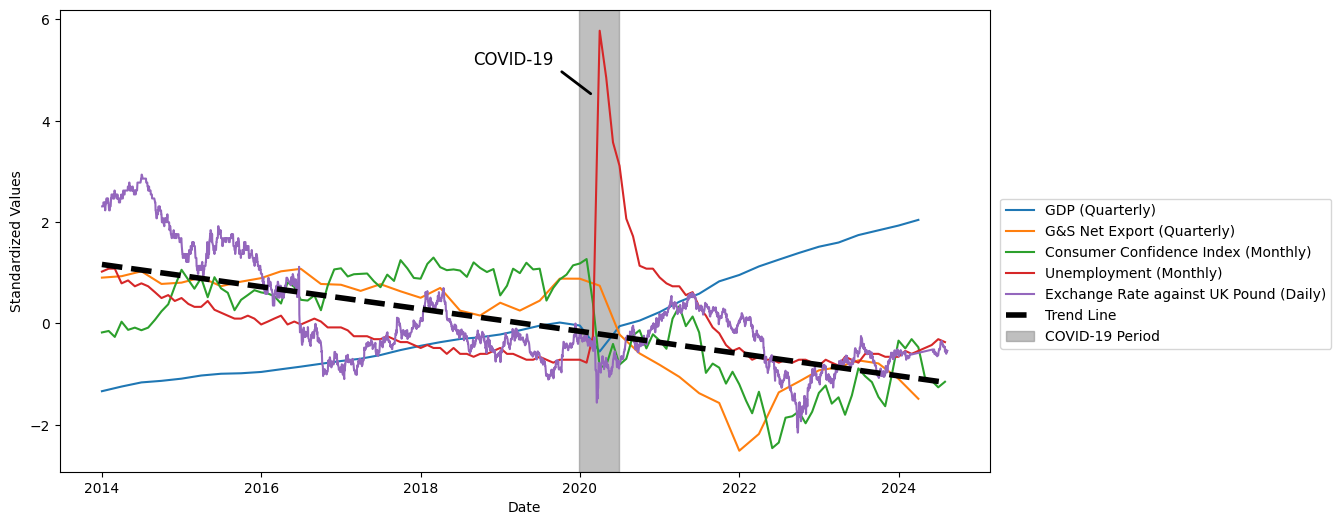

In [66]:
# Plotting
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
covariates_quarterly = quarterly_data.columns.difference(['date'])
covariate_labels_quarterly = ['GDP (Quarterly)', 'G&S Net Export (Quarterly)']

def df_standardizer(df, start_year, date_label):
    df[date_label] = pd.to_datetime(df[date_label])
    df = df[df[date_label] >= f'{start_year}-01-01']
    df = df.dropna() # removing the dates
    dates = df[date_label]
    for column in df.columns.difference([date_label]):
        df.loc[:, column] = pd.to_numeric(df[column].astype(str).str.replace(',', ''), errors='coerce')
        df.loc[:,column] = pd.to_numeric(df[column], errors='coerce')  # Convert back to numeric
        df.loc[:,column] = df[column].astype(float) 
    columns_to_standardize = df.columns.difference([date_label])
    data_to_standardize = df[columns_to_standardize]
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(data_to_standardize)
    standardized_df = pd.DataFrame(standardized_data, columns=columns_to_standardize)
    standardized_df = pd.concat([dates.reset_index(drop=True), standardized_df.reset_index(drop=True)], axis=1)
    return(standardized_df)

covariates_monthly = monthly_data.columns.difference(['date'])
covariate_labels_monthly = ['Consumer Confidence Index (Monthly)', 'Unemployment (Monthly)']
standardized_df_monthly = df_standardizer(monthly_data,2014, 'date')

covariates_daily = daily_data.columns.difference(['date'])
covariate_labels_daily = ['Exchange Rate against UK Pound (Daily)']
standardized_df_daily = df_standardizer(daily_data,2014, 'date')

standardized_df_quarterly = df_standardizer(quarterly_data,2014, 'date')
plt.figure(figsize=(12, 6))
# Plot each covariate as a line on the same graph
for i in range(len(covariates_quarterly)):
    covariate_name = covariates_quarterly[i]
    label = covariate_labels_quarterly[i]
    plt.plot(standardized_df_quarterly['date'], standardized_df_quarterly[covariate_name], label=label)

for i in range(len(covariates_monthly)):
    covariate_name = covariates_monthly[i]
    label = covariate_labels_monthly[i]
    plt.plot(standardized_df_monthly['date'], standardized_df_monthly[covariate_name], label=label)
plt.plot(standardized_df_daily['date'], standardized_df_daily['pound_dollar_exchange_rate'], label=covariate_labels_daily[0])

X = np.arange(len(standardized_df_monthly)).reshape(-1, 1)  # Use index as feature
y = standardized_df_monthly["ics"].values  # The selected covariate

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict values for the trend line
trend_line = model.predict(X)

# Plot the trend line
plt.plot(standardized_df_monthly['date'], trend_line, color='black', linestyle='--', linewidth=4, label='Trend Line')

plt.axvspan(pd.to_datetime('2019-12-30'), pd.to_datetime('2020-06-30'), color='gray', alpha=0.5, label='COVID-19 Period')
plt.text(pd.to_datetime('2018-08-30'), 5.1, 'COVID-19', fontsize=12, color='black')
plt.annotate(
    '',  # No label for the arrow itself
    xy=(pd.to_datetime('2020-03-01'), 4.5),  # End point of the arrow (somewhere between the vertical lines)
    xytext=(pd.to_datetime('2019-09-30'), 5),  # Start point of the arrow (position of the text)
    arrowprops=dict(arrowstyle='-', color='black',linewidth=2, linestyle='-')  # Line style and color
)

# plt.title('Macroeconomic Variables over Time')
plt.xlabel('Date')
plt.ylabel('Standardized Values')
plt.legend(loc='lower right', bbox_to_anchor=(1.375, 0.25))
plt.savefig('macro_variables.png', bbox_inches='tight')

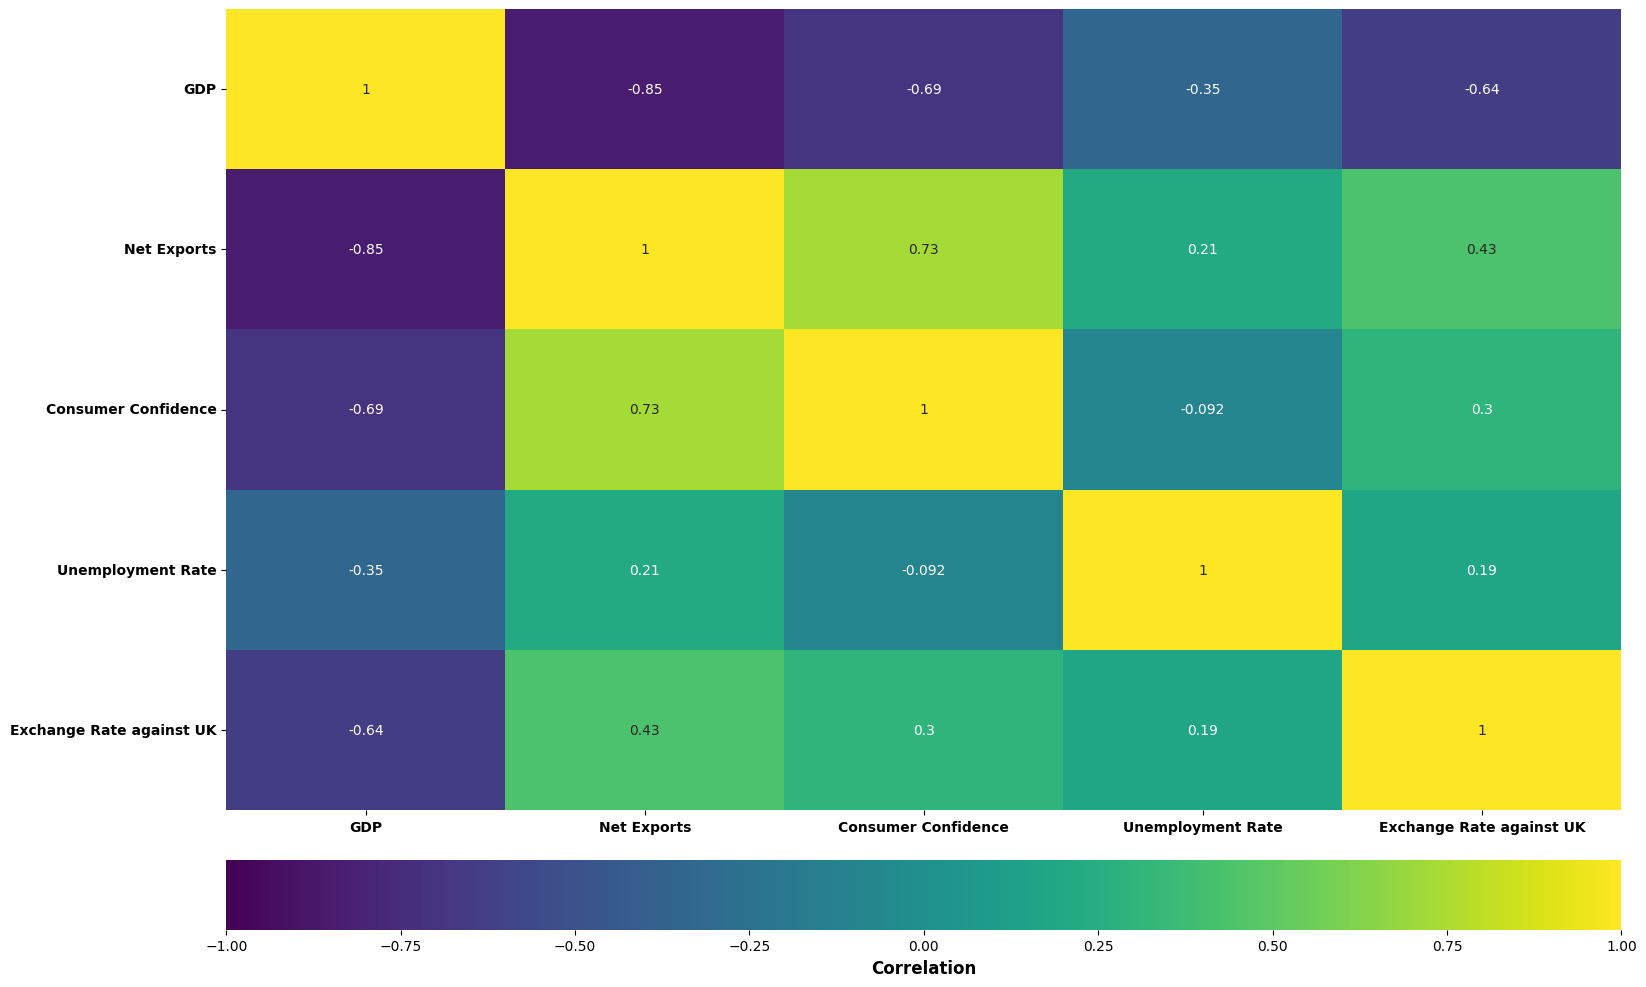

In [91]:
combined_df = pd.merge_asof(standardized_df_quarterly.sort_values('date'), 
                             standardized_df_monthly.sort_values('date'), 
                             on='date', 
                             direction='nearest')
combined_df = pd.merge_asof(combined_df.sort_values('date'), 
                             standardized_df_daily.sort_values('date'), 
                             on='date', 
                             direction='nearest')
# combined_df
col_excl_date = combined_df.drop('date',axis=1)
corr_matrix = col_excl_date.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(18, 13))
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='viridis', vmin=-1, vmax=1,cbar_kws={'label': '','orientation':'horizontal','pad':0.05})
colorbar = heatmap.collections[0].colorbar
# Set the label and make it bold
colorbar.set_label('Correlation', fontsize=12, fontweight='bold')  # Set font weight to bold
heatmap.set_xticklabels(['GDP', 'Net Exports', 'Consumer Confidence', 'Unemployment Rate', "Exchange Rate against UK"], rotation=0,fontsize=10,fontweight='bold')  # x-axis labels
heatmap.set_yticklabels(['GDP', 'Net Exports', 'Consumer Confidence', 'Unemployment Rate', "Exchange Rate against UK"], rotation=0,fontsize=10,fontweight='bold')   # y-axis labels

plt.savefig('macro_corr_matrix.png')

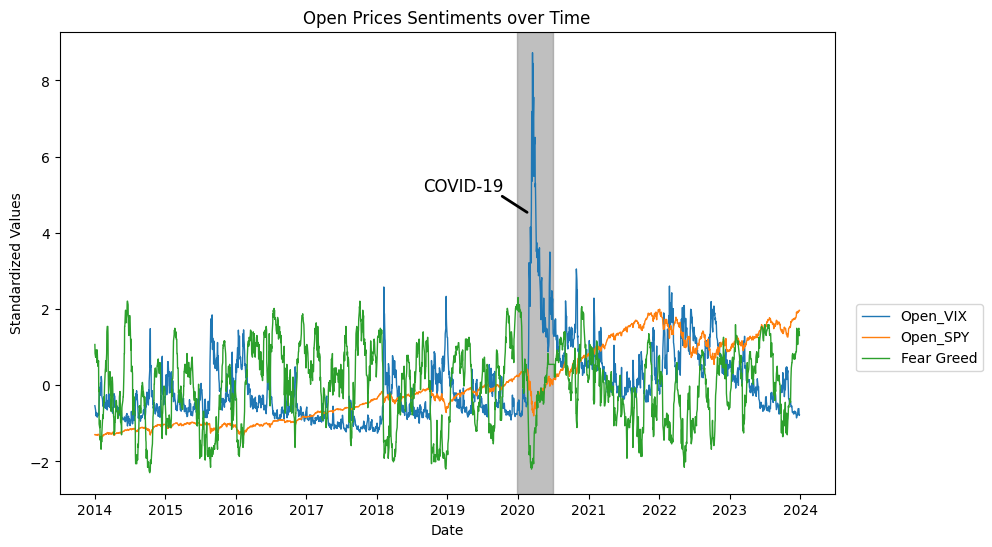

In [64]:
# Plotting of Investor Sentiments
vix_greed = pd.read_csv(os.path.join(os.path.dirname(current_loc), 'Model Pipeline', 'datasets', 'VIX_feargreed','spy_vix_fear_greed_2011_2023.csv'))
def greed_plotter(df, start_year, plotting_type):
    df['Date'] = pd.to_datetime(df['Date'])
    df_new = df[['Date',f'{plotting_type}_VIX',f'{plotting_type}_SPY', 'Fear Greed']]
    filtered_df = df_new[df_new['Date'] >= f'{start_year}-01-01']
    variables = [f'{plotting_type}_VIX',f'{plotting_type}_SPY', 'Fear Greed']
    graph_labels = [f'{plotting_type}_VIX',f'{plotting_type}_SPY', 'Fear Greed']
    
    columns_to_standardize = filtered_df.columns.difference(['Date'])
    data_to_standardize = filtered_df[columns_to_standardize]
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(data_to_standardize)
    standardized_df = pd.DataFrame(standardized_data, columns=columns_to_standardize)
    
    plt.figure(figsize=(10, 6))
    for i in range(len(graph_labels)):
        plt.plot(filtered_df['Date'], standardized_df[variables[i]], label=graph_labels[i], linewidth=1)
    plt.title(f'{plotting_type} Prices Sentiments over Time')
    plt.xlabel('Date')
    plt.ylabel('Standardized Values')
    plt.legend(loc='lower right', bbox_to_anchor=(1.2, 0.25))
    plt.axvspan(pd.to_datetime('2019-12-30'), pd.to_datetime('2020-06-30'), color='gray', alpha=0.5, label='COVID-19 Period')
    plt.text(pd.to_datetime('2018-08-30'), 5.1, 'COVID-19', fontsize=12, color='black')
    plt.annotate(
        '',  # No label for the arrow itself
        xy=(pd.to_datetime('2020-03-01'), 4.5),  # End point of the arrow (somewhere between the vertical lines)
        xytext=(pd.to_datetime('2019-09-30'), 5),  # Start point of the arrow (position of the text)
        arrowprops=dict(arrowstyle='-', color='black',linewidth=2, linestyle='-')  # Line style and color
    )
    plt.savefig('greedy_index_sp500_greed.png', bbox_inches='tight')
    plt.show()
    return

greed_plotter(vix_greed, 2014, "Open")

1. EBITDA Ratio - Earnings before Interest, Taxes, Depreciation, and Amortization
- Measure a company's overall financial performance and profitability
- Higher = Company is more efficient at converting revenue into actual earnings

2. Price to Book Ratio
- Compares its market value (current share price) to its book value (value of assets - liabilities)
- > 1 = overvaluation, < 1 = undervaluation

3. Price to Earnings Ratio
- Company's Current Share price relative to earnings per share (EPS)
- Higher = Investers expect future growth, Lower = company may be facing some difficulties

4. Returns on Equity
- Ability of a company to generate profits from its shareholders' equity (for every dollar of equity)

5. Price to Sales Ratio
- Compares stock price to revenues per share
- Lower ratio = undervalued

In [45]:
# Visualisation of Fundamental Indicators
dbitda_ratio = pd.read_csv(os.path.join(os.path.dirname(current_loc), 'data', 'fundamental indicators', 'DBITDA_ratio.csv'))
pb_ratio = pd.read_csv(os.path.join(os.path.dirname(current_loc), 'data', 'fundamental indicators', 'PB_ratio.csv'))
pe_ratio = pd.read_csv(os.path.join(os.path.dirname(current_loc), 'data', 'fundamental indicators', 'PE_ratio.csv'))
ps_ratio = pd.read_csv(os.path.join(os.path.dirname(current_loc), 'data', 'fundamental indicators', 'PS_ratio.csv'))
roe = pd.read_csv(os.path.join(os.path.dirname(current_loc), 'data', 'fundamental indicators', 'ROE.csv'))

# Merging files by date
dbitda_ratio['Date'] = pd.to_datetime(dbitda_ratio['Date'], format='%d/%m/%Y')
dbitda_ratio = dbitda_ratio.drop(["TTM Revenue(Billion)","TTM EBITDA(Billion)"],axis=1)

pb_ratio['Date'] = pd.to_datetime(pb_ratio['Date'], format='%d/%m/%Y')
pb_ratio = pb_ratio.drop(["Stock Price","Book Value per Share"],axis=1)

pe_ratio['Date'] = pd.to_datetime(pe_ratio['Date'], format='%d/%m/%Y')
pe_ratio = pe_ratio.drop(["Stock Price","Net EPS"],axis=1)

ps_ratio['Date'] = pd.to_datetime(ps_ratio['Date'], format='%d/%m/%Y')
ps_ratio = ps_ratio.drop(["Stock Price","TTM Sales per Share"],axis=1)

roe['Date'] = pd.to_datetime(roe['Date'], format='%d/%m/%Y')
roe = roe.drop(["TTM Net Income (Billions)","Shareholder's Equity (Billion)"],axis=1)

dbitda_ratio_filtered = dbitda_ratio[dbitda_ratio['Date'] >= pd.to_datetime('2014-01-01')]
pb_ratio_filtered = pb_ratio[pb_ratio['Date'] >= pd.to_datetime('2014-01-01')]
dbitda_ratio_filtered = dbitda_ratio_filtered.sort_values(by=['Company', 'Date'])
pb_ratio_filtered = pb_ratio_filtered.sort_values(by=['Company', 'Date'])

combined_df = dbitda_ratio_filtered.merge(pb_ratio_filtered, on=['Company','Date'], how='left').merge(pe_ratio, on=['Company','Date'], how='left').merge(roe, on=['Company','Date'], how='left').merge(ps_ratio, on = ['Company','Date'], how='left')
combined_df.head()

,Date,EBITDA Margin,Company,Price to Book Ratio,PE Ratio,Return on Equity(%),Price to Sales Ratio
0,2014-03-31,32.83,APPL,3.38,11.27,13.34,2.43
1,2014-06-30,33.19,APPL,4.07,13.26,13.30,2.88
2,2014-09-30,33.07,APPL,4.70,13.91,13.48,3.02
3,2014-12-31,33.87,APPL,4.65,13.27,12.41,2.97
4,2015-03-31,34.38,APPL,4.98,13.77,11.07,3.12


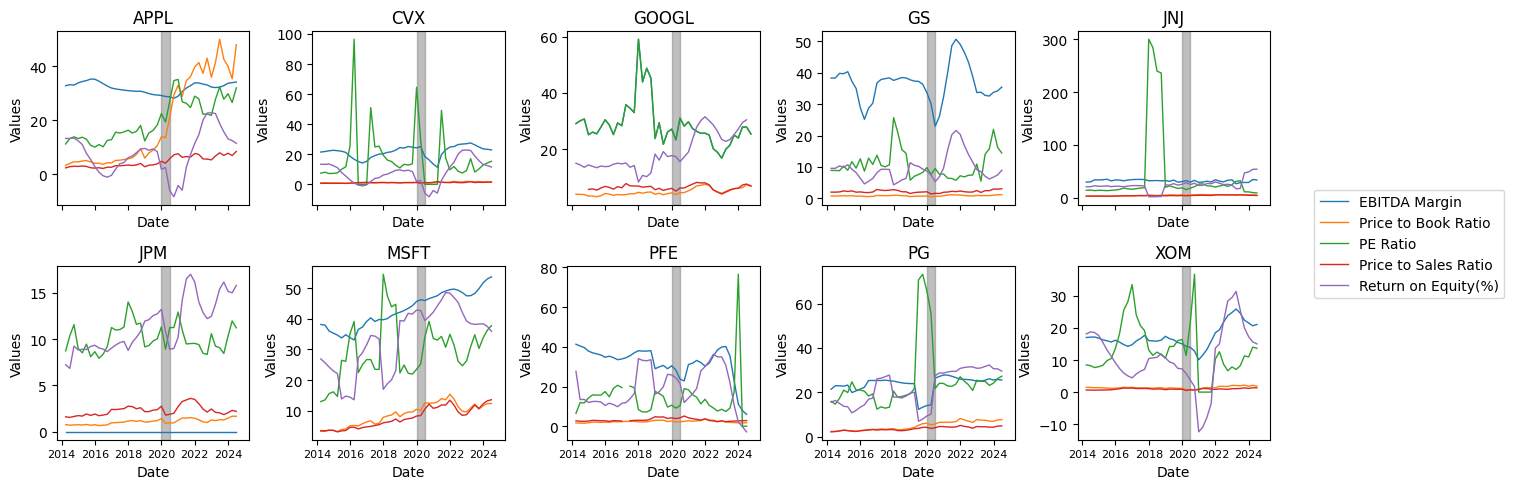

In [67]:
def fundamental_plotter(df, start_year):
    df['Date'] = pd.to_datetime(df['Date'])
    df.loc[df['Company'] == 'GOOG', 'Company'] = 'GOOGL'
    # Filter by start year
    filtered_df = df[df['Date'] >= f'{start_year}-01-01']
    
    # Unique companies
    companies = filtered_df['Company'].unique()
    
    # Number of companies and layout (e.g., 5 rows and 2 columns for 10 companies)
    n_companies = len(companies)
    n_cols = 5 # You can change this to control the number of columns
    n_rows = int(np.ceil(n_companies / n_cols))
    
    # Define labels and variables to plot
    graph_labels = ['EBITDA Margin', 'Price to Book Ratio', 'PE Ratio', 'Price to Sales Ratio', 'Return on Equity(%)']
    variables = ['EBITDA Margin', 'Price to Book Ratio', 'PE Ratio', 'Price to Sales Ratio', 'Return on Equity(%)']
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 2.5), sharex=True)
    axes = axes.flatten()  # Flatten the axes array for easy indexing
    
    # Plot data for each company
    for i, company in enumerate(companies):
        company_df = filtered_df[filtered_df['Company'] == company]
        
        for j in range(len(graph_labels)):
            axes[i].plot(company_df['Date'], company_df[variables[j]], label=graph_labels[j], linewidth=1)
        
        axes[i].set_title(company)
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Values')
        axes[i].tick_params(axis='x', labelsize=8)
        # Add COVID-19 shading and annotation
        axes[i].axvspan(pd.to_datetime('2019-12-30'), pd.to_datetime('2020-06-30'), color='gray', alpha=0.5)

    lines, labels = [], []
    for ax in axes.flat:
        for line in ax.get_lines():
            lines.append(line)
            labels.append(line.get_label())

    # Add a shared legend for all plots
    fig.legend(lines[0:5], labels[0:5], loc='center left', bbox_to_anchor=(0.875, 0.5))  # Adjust bbox_to_anchor as needed
    # fig.suptitle('Fundamental Factors among Companies', fontsize=16)
    
    plt.tight_layout() # Adjust layout to avoid overlap
    plt.subplots_adjust(right=0.85)
    plt.savefig('fundamental_factors.png', bbox_inches='tight')
    plt.show()

# Example usage
fundamental_plotter(combined_df, 2014)

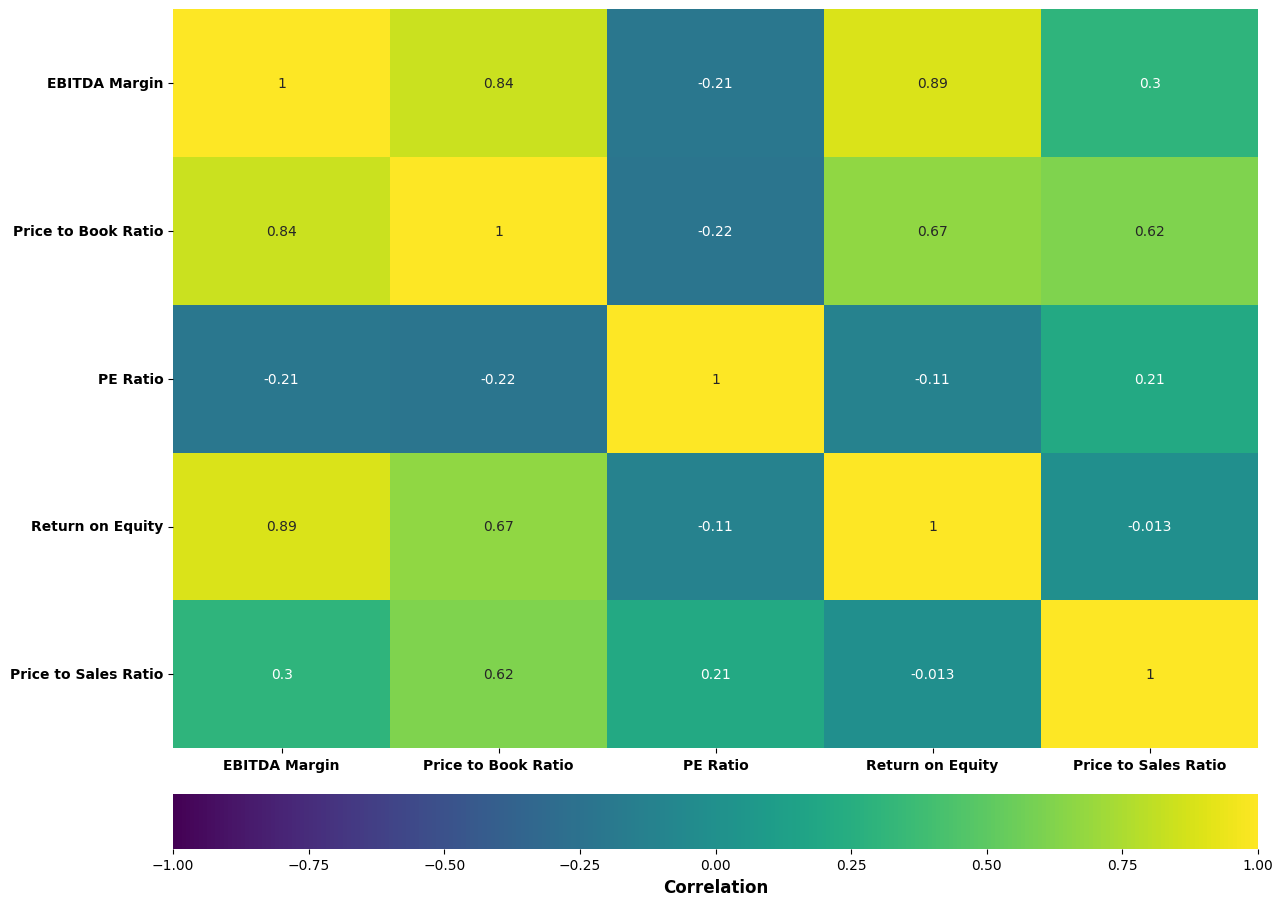

In [90]:
xom = combined_df[combined_df['Company']=="XOM"]

col_excl_date = xom.drop(['Date','Company'],axis=1)
corr_matrix = col_excl_date.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='viridis', vmin=-1, vmax=1,cbar_kws={'label': '','orientation':'horizontal','pad':0.05})
colorbar = heatmap.collections[0].colorbar
# Set the label and make it bold
colorbar.set_label('Correlation', fontsize=12, fontweight='bold')  # Set font weight to bold

heatmap.set_xticklabels(['EBITDA Margin', 'Price to Book Ratio', 'PE Ratio', 'Return on Equity', 'Price to Sales Ratio'], rotation=0, fontsize=10, fontweight='bold')
heatmap.set_yticklabels(['EBITDA Margin', 'Price to Book Ratio', 'PE Ratio', 'Return on Equity', 'Price to Sales Ratio'], fontsize=10,rotation=0, fontweight='bold')
plt.savefig('fundamental_factor_corr_matrix.png')

In [71]:
# Loading Stock Data
stock_data = pd.read_csv(os.path.join(os.path.dirname(current_loc), 'data', 'fundamental indicators', 'stock_data.csv'))
# stock_data.head()
def data_cleaner(df, start_year, variable_name, variable_label):
    df['Date'] = pd.to_datetime(df['Date'])
    df_filtered = df[df['Date'] >= f'{start_year}-01-01']
    df_filtered = df_filtered[df_filtered['Stock'] != 'UL']
    final = df_filtered[['Date', 'Stock', variable_name,"BOLL_Upper","BOLL_Lower"]]
    
    plt.figure(figsize=(10, 6))

    for i in range(len(final['Stock'].unique())):
        name = final['Stock'].unique()[i]
        company_data = final[final['Stock'] == name]
        plt.plot(company_data['Date'], company_data[variable_name], label=name,linewidth=1.5 )
        

    plt.title(f'{variable_label} over Time')
    plt.xlabel('Date')
    plt.ylabel(variable_label)
    plt.legend(loc='lower right', bbox_to_anchor=(1.2, 0.25))
    plt.axvspan(pd.to_datetime('2019-12-30'), pd.to_datetime('2020-06-30'), color='gray', alpha=0.5, label='COVID-19 Period')
    plt.text(pd.to_datetime('2018-08-30'), 480, 'COVID-19', fontsize=12, color='black')
    plt.annotate(
        '',  # No label for the arrow itself
        xy=(pd.to_datetime('2020-03-01'), 400),  # End point of the arrow (somewhere between the vertical lines)
        xytext=(pd.to_datetime('2019-09-30'), 475),  # Start point of the arrow (position of the text)
        arrowprops=dict(arrowstyle='-', color='black',linewidth=2, linestyle='-')  # Line style and color
    )
    
    plt.savefig('stock_prices_open.png', bbox_inches='tight')
    plt.show()
    return

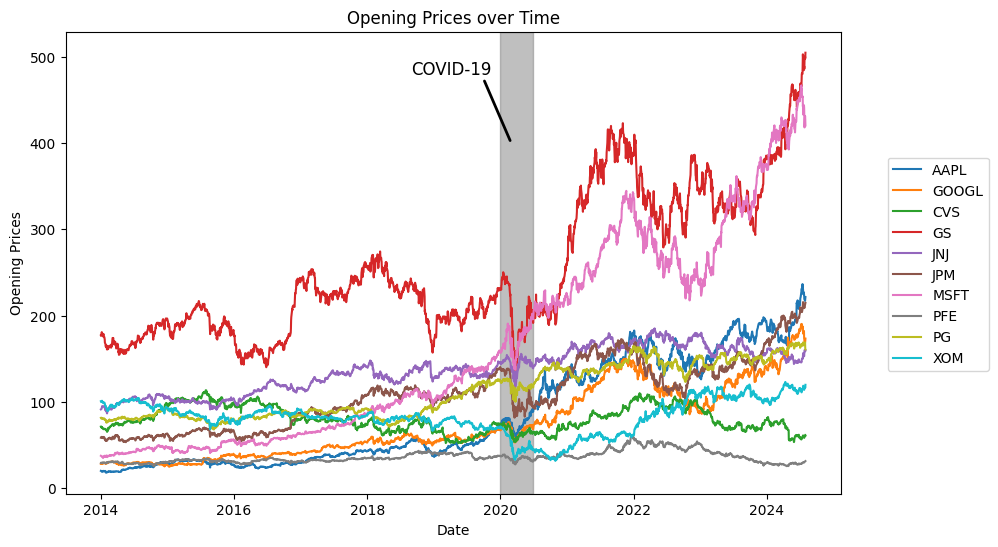

In [72]:
data_cleaner(stock_data, 2014, 'Open', 'Opening Prices')

In [94]:
def data_cleaner_boll(df, start_year, variable_name, variable_label, stock_evaluator):
    df['Date'] = pd.to_datetime(df['Date'])
    df_filtered = df[df['Date'] >= f'{start_year}-01-01']
    df_filtered = df_filtered[df_filtered['Stock'] != 'GOOGL']
    final = df_filtered[['Date', 'Stock', variable_name,"BOLL_Upper","BOLL_Lower"]]
    # color = ["b","g","c","m","y","darkgoldenrod","indigo","slategrey","dodgerblue","mediumspringgreen"]
    
    plt.figure(figsize=(10, 6))

    for i in range(len(final['Stock'].unique())):
        # colour = color[i]
        name = final['Stock'].unique()[i]
        company_data = final[final['Stock'] == name]
        plt.plot(company_data['Date'], company_data[variable_name], label=name, linewidth=1 )
        plt.fill_between(company_data['Date'], 
                     company_data["BOLL_Upper"], 
                     company_data["BOLL_Lower"], 
                     color='darkgrey', alpha=0.5)
        

    plt.title(f'{variable_label} over Time with {stock_evaluator}')
    plt.xlabel('Date')
    plt.ylabel(variable_label)
    plt.legend(loc='lower right', bbox_to_anchor=(1.2, 0.25))
    
    plt.show()
    return

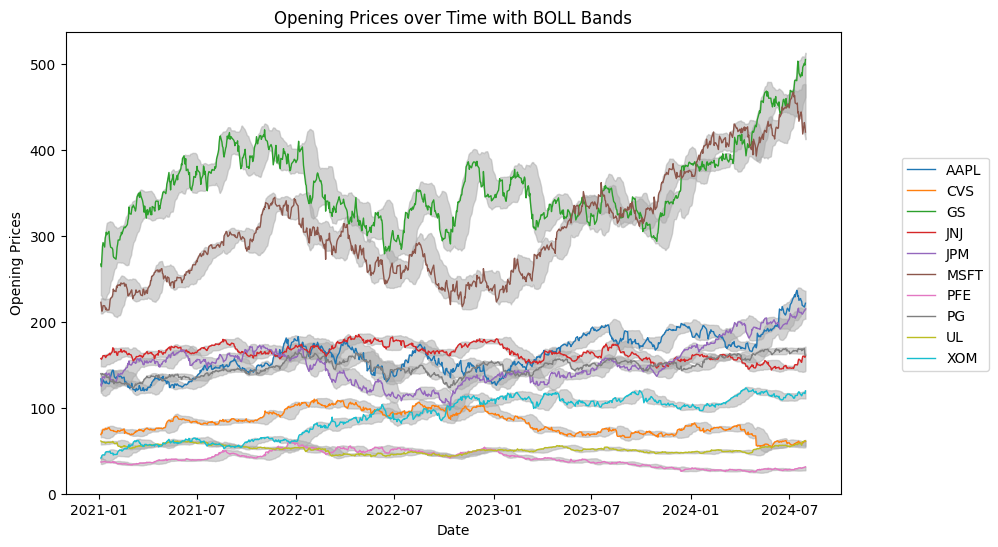

In [95]:
data_cleaner_boll(stock_data, 2021, 'Open', 'Opening Prices','BOLL Bands')